# Synthetic spectral synthesis

We are going to make fake data to understand how stellar specrtra work.

In [1]:
#import numpy as np
import jax.numpy as np  ## Next step

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The data exist as a table of wavelength, flux, and flux uncertainty.  
You can think of the wavelength values as corresponding to the near-IR in micron.

In [54]:
wl = np.linspace(2.0, 2.4, 10000)

The specrral lines will all be absorption lines with Gaussian line profiles:
$$ $$
$$\mathrm{abs}(\lambda) = A \cdot e^{-\frac{1}{2}\left((\lambda-\lambda_0)/\sigma\right)^2 }$$

The free paramters for the line are the line center position $\lambda_0$, depth $A$, and linewidth $\sigma$.

In [4]:
def line_profile(location, depth, width):
    """Make a spectral line"""
    return depth * np.exp(-0.5*((wl-location)/width)**2)

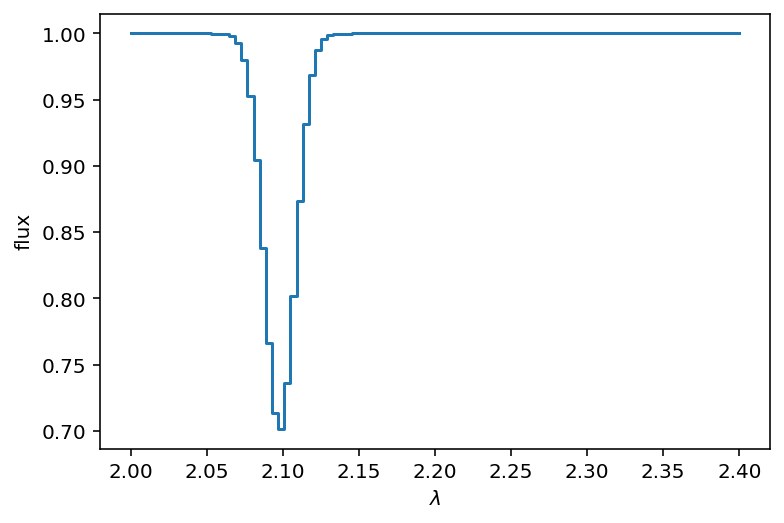

In [5]:
plt.step(wl, 1-line_profile(2.1, 0.3, 0.01))
plt.xlabel('$\lambda$'); plt.ylabel('flux');

We're going to make a function that generates fake flux values.
This spectrum has 3 distinct lines:  
- $\lambda=2.1$ the amplitude depends only on $T_{\mathrm{eff}}$
- $\lambda=2.2$ the linewidth depends only on $\log{g}$
- $\lambda=2.3$ increases linearly with $[\mathrm{Fe}/\mathrm{H}]$

In [35]:
def synthetic_spectrum(a):
    """generate a synthetic spectrum"""
    teff, logg, fe_h = a 
    amp1 = 0.6*np.exp(-((teff-2700)/500)**2)
    line1 = line_profile(2.1, amp1, 0.01)
    
    width2 = 0.01 + 0.002*(0.5+np.arctan( ((logg - 3)/0.5) / (np.pi/4) ))
    line2 = line_profile(2.2, 0.3, width2)
    
    amp3 = 0.0 + 0.1*np.sqrt(6+fe_h)
    line3 = line_profile(2.3, amp3, 0.01)
    
    net_flux = 1 - (line1 + line2 + line3)
    return net_flux

In [7]:
flux = synthetic_spectrum((2700, 3.5, 0.0))

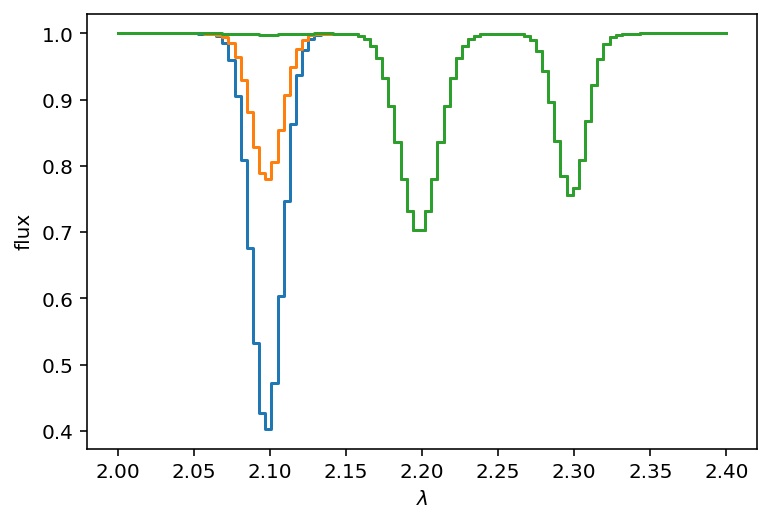

In [8]:
plt.step(wl, flux);
plt.step(wl, synthetic_spectrum((2200, 3.5, 0.0)))
plt.step(wl, synthetic_spectrum((3900, 3.5, 0.0)))
plt.xlabel('$\lambda$'); plt.ylabel('flux');

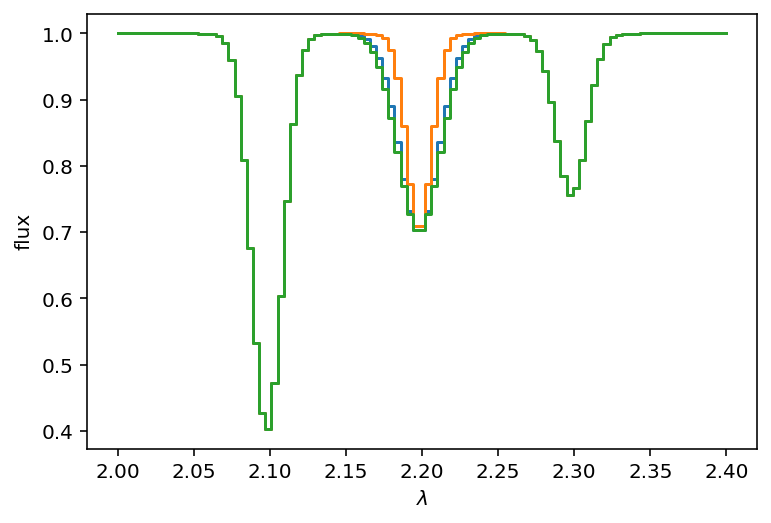

In [9]:
plt.step(wl, flux);
plt.step(wl, synthetic_spectrum((2700, 0.5, 0.0)))
plt.step(wl, synthetic_spectrum((2700, 6.0, 0.0)))
plt.xlabel('$\lambda$'); plt.ylabel('flux');

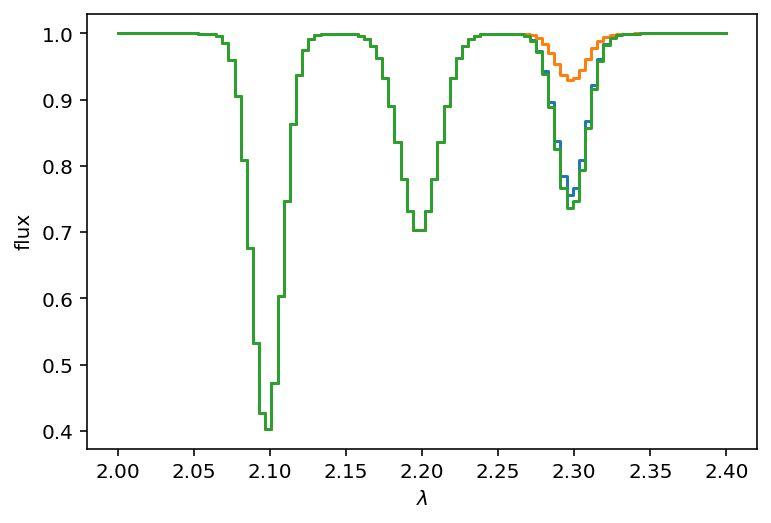

In [10]:
plt.step(wl, flux);
plt.step(wl, synthetic_spectrum((2700, 3.5, -5.5)))
plt.step(wl, synthetic_spectrum((2700, 3.5, 1.0)))
plt.xlabel('$\lambda$'); plt.ylabel('flux');

Next step: use jax to get: 
$$ \frac{\partial f(\lambda)}{\partial T_{\mathrm{eff} }}, \frac{\partial f(\lambda)}{\partial \log{g}}, \frac{\partial f(\lambda)}{\partial [\mathrm{Fe}/\mathrm{H}]}$$

To be continued at the Ames Hack Day!

In [46]:
from jax import grad, jit, vmap, jacfwd, jacrev

In [55]:
%timeit F = jacfwd(synthetic_spectrum)((3000.0, 0.1, 0.0))
%timeit R = jacrev(synthetic_spectrum)((3000.0, 0.1, 0.0))

14.4 ms ± 1.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.69 s ± 59.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


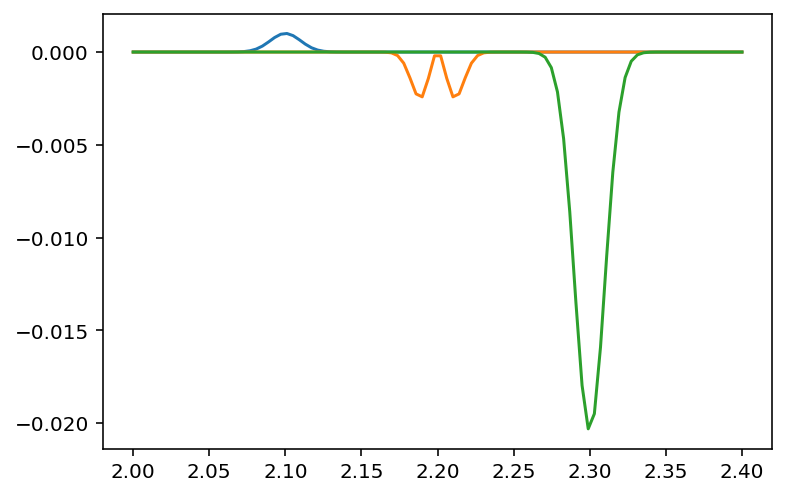

In [49]:
for i in R: plt.plot(wl,i)

In [56]:
def synthetic_spectrum(a):
    """generate a synthetic spectrum"""
    teff, logg, fe_h = a 
    t1, t2, t3 = teff
    amp1 = (0.2*np.exp(-((t1-1200)/300)**2) +
           0.3*np.exp(-((t2-1250)/400)**2) +
           0.4*np.exp(-((t3-1300)/500)**2) )
    line1 = line_profile(2.1, amp1, 0.01)
    
    width2 = 0.01 + 0.002*(0.5+np.arctan( ((logg - 3)/0.5) / (np.pi/4) ))
    line2 = line_profile(2.2, 0.3, width2)
    
    amp3 = 0.0 + 0.1*np.sqrt(6+fe_h)
    line3 = line_profile(2.3, amp3, 0.01)
    
    net_flux = 1 - (line1 + line2 + line3)
    return net_flux

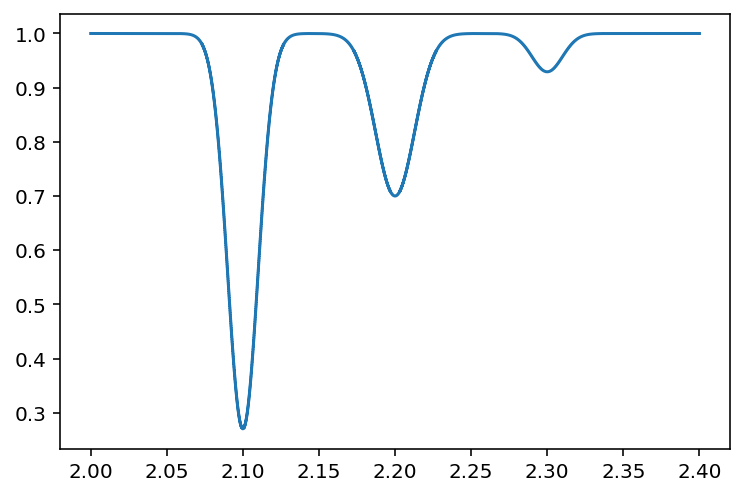

In [71]:
plt.step(wl, synthetic_spectrum(((1000,1400,1500), 3.5, -5.5)))

In [69]:
F = jacfwd(synthetic_spectrum)(((1000.0,1400.0,1500.0), 0.1, 0.0))

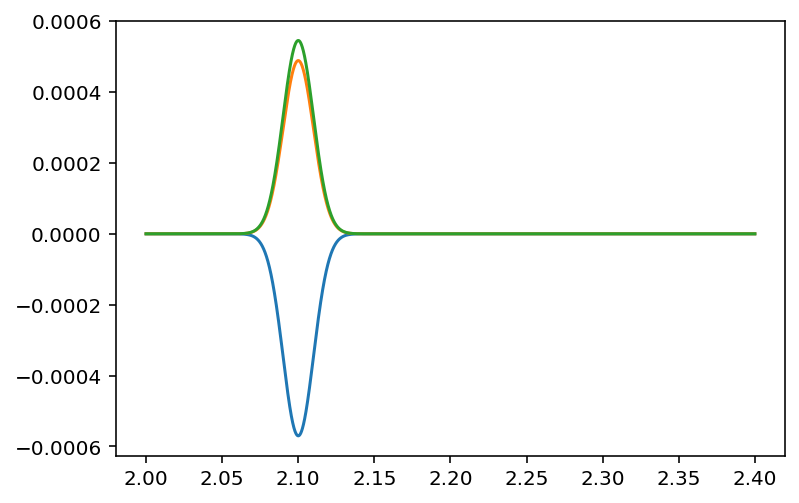

In [70]:
for i in F[0]: plt.plot(wl,i)